In [1]:
# Retrives data from URL and saves it to the file system
!kaggle datasets download -d stackoverflow/stackoverflow -p datasets/stack_stats
#!unzip datasets/stack_stats/suicide-rates-overview-1985-to-2016

403 - This is a BigQuery Dataset. There are no files to download, but you can query it through Kernels.


In [2]:
# Install the package with: pip install -e git+https://github.com/SohierDane/BigQuery_Helper#egg=bq_helper
#!pip install -e git+https://github.com/SohierDane/BigQuery_Helper#egg=bq_helper

In [3]:
#I've created an API key for this project and included it in the project folder.
#I would never store an API key in this way for a real project, it is only included this way for this demo
#https://cloud.google.com/docs/authentication/getting-started
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="Stack Overflow Project.json"
#!set GOOGLE_APPLICATION_CREDENTIALS="C:\Users\karth\Documents\MLprojects\Stack Overflow\Stack Overflow Project.json"

In [4]:
import bq_helper
from bq_helper import BigQueryHelper
import pandas as pd
stackOverflow = bq_helper.BigQueryHelper(active_project="bigquery-public-data", dataset_name="stackoverflow")

stackOverflow.list_tables()

['badges',
 'comments',
 'post_history',
 'post_links',
 'posts_answers',
 'posts_moderator_nomination',
 'posts_orphaned_tag_wiki',
 'posts_privilege_wiki',
 'posts_questions',
 'posts_tag_wiki',
 'posts_tag_wiki_excerpt',
 'posts_wiki_placeholder',
 'stackoverflow_posts',
 'tags',
 'users',
 'votes']

In [5]:

query_get_answers = """ Select questions.title as question_title, questions.body as question_body, questions.answer_count as question_answer_count,users_question.reputation as question_users_reputation,
users_answer.display_name as answer_user_name, answers.score as answer_score , users_answer.reputation as answer_users_reputation,
questions.id as question_id,  questions.owner_user_id as question_owner_user_id, questions.score as question_score, 
users_question.display_name as question_user_name,questions.tags

from `bigquery-public-data.stackoverflow.posts_questions` as questions
JOIN 
`bigquery-public-data.stackoverflow.posts_answers` as answers
on questions.id = answers.parent_id
JOIN
`bigquery-public-data.stackoverflow.users` as users_answer
on answers.owner_user_id = users_answer.id
JOIN 
`bigquery-public-data.stackoverflow.users` as users_question
on questions.owner_user_id = users_question.id
where answers.owner_user_id Is NOT NULL and questions.owner_user_id is not NULL and questions.tags is NOT NULL 
and Extract(Year from questions.creation_date)>2018

limit 10000
;

"""

stack_overflow_data = stackOverflow.query_to_pandas_safe(query_get_answers,30)
stack_overflow_data.to_csv('stack_overflow_question_data_10000.csv', index=False)
len(stack_overflow_data)

10000

In [6]:
stack_overflow_data.head()

,question_title,question_body,question_answer_count,question_users_reputation,answer_user_name,answer_score,answer_users_reputation,question_id,question_owner_user_id,question_score,question_user_name,tags
0,Highlight specific words in a sentence in python,"<p>I have some text, and I want to highlight s...",5,1217,s3nh,1,370,57251653,2123706,4,alex,python|termcolor
1,ESlint Error when using map - workaround?,<p>What is the workaround to update the <code>...,2,7951,tiagolisalves,1,134,57192045,791022,2,I'll-Be-Back,javascript|node.js|eslint|eslint-config-airbnb
2,Streaming python command executed over ssh in ...,"<p>While ssh'ed into a bastion host, I'm execu...",1,195,abdusco,0,2757,57066148,5330107,0,Victor Cui,python
3,Sorting documents in N1QL using array field of...,<p>We need to sort documents using array field...,1,91,vsr,2,2714,56543953,5105808,0,Momin Fakhruddin,sorting|couchbase|n1ql
4,What's the difference between Microsoft.CodeAn...,<p>I want to install code analysis to one of m...,1,394,George Alexandria,2,2407,55683923,1503963,4,Andrej Lučanský,c#|code-analysis|roslyn-code-analysis


In [7]:
stack_overflow_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
question_title               10000 non-null object
question_body                10000 non-null object
question_answer_count        10000 non-null int64
question_users_reputation    10000 non-null int64
answer_user_name             10000 non-null object
answer_score                 10000 non-null int64
answer_users_reputation      10000 non-null int64
question_id                  10000 non-null int64
question_owner_user_id       10000 non-null int64
question_score               10000 non-null int64
question_user_name           10000 non-null object
tags                         10000 non-null object
dtypes: int64(7), object(5)
memory usage: 937.6+ KB


In [8]:
stack_overflow_data.describe()

,question_answer_count,question_users_reputation,answer_score,answer_users_reputation,question_id,question_owner_user_id,question_score
count,10000.000000,10000.000000,10000.000000,10000.00000,1.000000e+04,1.000000e+04,10000.000000
mean,1.867000,913.014900,0.810500,25506.22720,5.585042e+07,7.259981e+06,0.460000
std,1.114466,3463.540634,1.475875,84064.19434,1.060680e+06,3.755437e+06,1.707188
min,1.000000,1.000000,-5.000000,1.00000,5.399261e+07,2.122000e+03,-10.000000
25%,1.000000,23.000000,0.000000,260.00000,5.496229e+07,4.000653e+06,0.000000
50%,2.000000,101.000000,0.000000,1562.00000,5.584113e+07,8.193698e+06,0.000000
75%,2.000000,684.000000,1.000000,11094.25000,5.675136e+07,1.087868e+07,1.000000
max,8.000000,195671.000000,46.000000,910732.00000,5.774261e+07,1.200083e+07,29.000000


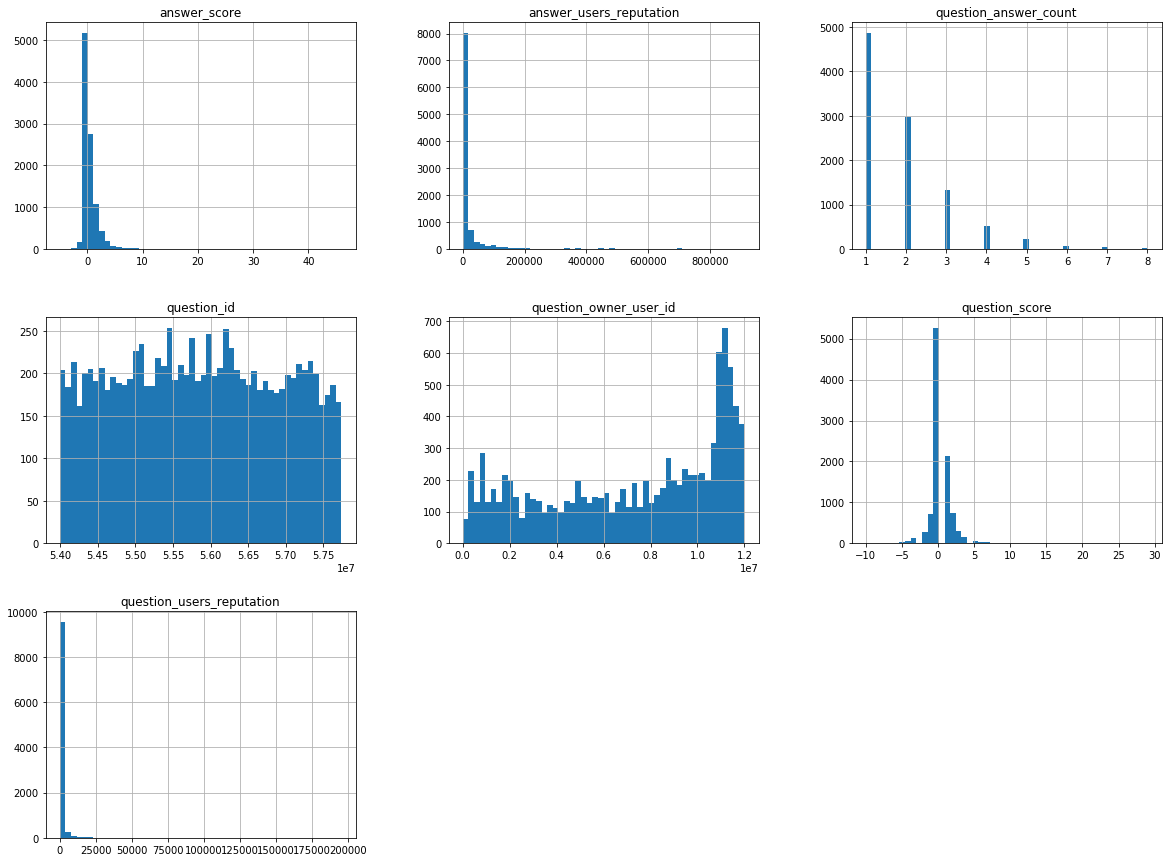

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
stack_overflow_data.hist(bins=50, figsize=(20,15))
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000265C8CC5C88>,
      dtype=object)

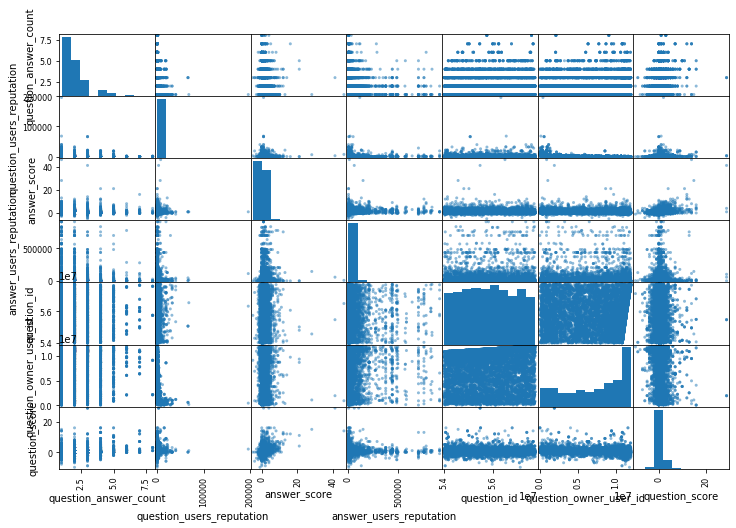

In [10]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(stack_overflow_data, figsize=(12, 8)) #[attributes]

In [11]:
#housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

In [12]:
#!pip install politeness
!cd stanford-corenlp-full-2018-10-05
#https://stanfordnlp.github.io/CoreNLP/#download
!java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 15000
print("test")

test


Error: Could not find or load main class edu.stanford.nlp.pipeline.StanfordCoreNLPServer
Caused by: java.lang.ClassNotFoundException: edu.stanford.nlp.pipeline.StanfordCoreNLPServer


In [13]:
import politeness
from politeness.classifier import Classifier
from politeness.helpers import set_corenlp_url
set_corenlp_url('some-url.org:1234')

cls = Classifier()
stack_overflow_data["question_title"] = stack_overflow_data["question_title"]

ModuleNotFoundError: No module named 'politeness'